In [1]:
from google.colab import drive
drive.mount('cnontent/')

Drive already mounted at cnontent/; to attempt to forcibly remount, call drive.mount("cnontent/", force_remount=True).


In [2]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

In [3]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [4]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [5]:
def show_data_scheme(data, label, row = 4, col = 5, i = 1): # data 어떻게 생겼는지 plot
  plt.figure(figsize = (11, 8))
  for r in range(row):
    for c in range(col):
      s_data = np.array(data[i,...,0])
      plt.subplot(row, col, i)
      plt.imshow(s_data, 'gray')
      plt.axis('off')
      # plt.title(f'{label_value_list[label[i]]}')
      i+=1
  plt.show()

In [6]:
def balanced_data(data, label, border, n_train=1000, val_rate = 0.2):
  i, start=0,0
  d_train = l_train = d_val = l_val= None
  n_data_per_class = n_train
  n_val_per_class = int(n_data_per_class*val_rate)


  for idx, class_end in enumerate(border):
    if i ==0:
      val_end = n_data_per_class+n_val_per_class

      d_train = data[:n_data_per_class].copy()
      l_train = label[:n_data_per_class].copy()

      d_val = data[n_data_per_class:val_end].copy()
      l_val = label[n_data_per_class:val_end].copy()

      i+=1
    else:
      train_end = start+n_data_per_class
      val_end = train_end+n_val_per_class

      now_d_data = data[start:train_end].copy()
      now_l_train = label[start:train_end].copy()
      d_train = np.concatenate((d_train, now_d_data))
      l_train = np.concatenate((l_train, now_l_train))

      now_d_val = data[train_end:val_end].copy()
      now_l_val = label[train_end:val_end].copy()
      d_val = np.concatenate((d_val, now_d_val))
      l_val = np.concatenate((l_val, now_l_val))
    start += class_end
  return (d_train, l_train, d_val, l_val)

In [7]:
train_csv, test_csv = [], []
train_csv = pd.read_csv("./emnist-byclass-train.csv", header=None)
# test_csv = pd.read_csv("./emnist-byclass-test.csv", header=None)

In [8]:
data, label = convert_data_csv_to_numpy(train_csv, sorting = False)
train_csv = []

In [9]:
boundary = int(data.shape[0]*0.8)

train_data = data[:boundary]
train_label = label[:boundary]

In [10]:
dataset = [[x, y] for x, y, in zip(train_data, train_label)]
dataset.sort(key = lambda x : x[1])
train_data = np.array([n[0] for n in dataset])
train_label = np.array([n[1] for n in dataset])

In [11]:
border = np.unique(train_label, return_counts = True)[1]
print(min(border))
print(max(border))

1529
30717


In [12]:
border

array([27696, 30717, 27324, 28168, 26883, 25050, 27575, 28620, 27177,
       27062,  5188,  3074,  8085,  3661,  4001,  7372,  2004,  2534,
        9529,  3029,  1963,  4002,  7188,  6546, 20067,  6660,  2115,
        4059, 16561,  7770, 10051,  3686,  3762,  2191,  3815,  2159,
        8045,  4105,  2286,  8165, 19667,  2048,  2923,  7008,  2183,
        1529,  2002, 12298,  2081,  9121,  2222,  1977,  2413, 11163,
        2154, 14580,  2255,  2307,  2142,  2264,  1864,  2199])

In [13]:
mean_border = int(np.mean(border))
print(mean_border)

9005


In [14]:
rate_meanNborder, new_boundary = [], []
total_data = 0
for i, b in enumerate(border):
  now_rate = b/mean_border
  if now_rate>=1:
    final_rate = round(1/now_rate, 1)
    now_boundary = int((final_rate*border[i]))

  elif now_rate <1:
    final_rate = round(1/now_rate, 1)
    now_boundary = int(final_rate*border[i])

  rate_meanNborder.append(final_rate)
  new_boundary.append(now_boundary)
  print("new border", now_boundary, " 현재 border : ",b, "mean border와의 비율", round(now_rate,1), "최종 rate :", final_rate)
  total_data += now_boundary

new border 8308  현재 border :  27696 mean border와의 비율 3.1 최종 rate : 0.3
new border 9215  현재 border :  30717 mean border와의 비율 3.4 최종 rate : 0.3
new border 8197  현재 border :  27324 mean border와의 비율 3.0 최종 rate : 0.3
new border 8450  현재 border :  28168 mean border와의 비율 3.1 최종 rate : 0.3
new border 8064  현재 border :  26883 mean border와의 비율 3.0 최종 rate : 0.3
new border 10020  현재 border :  25050 mean border와의 비율 2.8 최종 rate : 0.4
new border 8272  현재 border :  27575 mean border와의 비율 3.1 최종 rate : 0.3
new border 8586  현재 border :  28620 mean border와의 비율 3.2 최종 rate : 0.3
new border 8153  현재 border :  27177 mean border와의 비율 3.0 최종 rate : 0.3
new border 8118  현재 border :  27062 mean border와의 비율 3.0 최종 rate : 0.3
new border 8819  현재 border :  5188 mean border와의 비율 0.6 최종 rate : 1.7
new border 8914  현재 border :  3074 mean border와의 비율 0.3 최종 rate : 2.9
new border 8893  현재 border :  8085 mean border와의 비율 0.9 최종 rate : 1.1
new border 9152  현재 border :  3661 mean border와의 비율 0.4 최종 rate : 2.5
new borde

In [15]:
total_data

553190

In [16]:
len(new_boundary)

62

In [17]:
print(train_data.shape)
print(total_data)

(558345, 28, 28, 1)
553190


In [18]:
print(new_boundary)

[8308, 9215, 8197, 8450, 8064, 10020, 8272, 8586, 8153, 8118, 8819, 8914, 8893, 9152, 9202, 8846, 9018, 9122, 8576, 9087, 9029, 9204, 9344, 9164, 8026, 9324, 9094, 8929, 8280, 9324, 9045, 8846, 9028, 8983, 9156, 9067, 8849, 9031, 8915, 8981, 9833, 9011, 9061, 9110, 8950, 9021, 9009, 8608, 8948, 9121, 9110, 9094, 8928, 8930, 9046, 8748, 9020, 8997, 8996, 9056, 8947, 9015]


In [19]:
print(border)

[27696 30717 27324 28168 26883 25050 27575 28620 27177 27062  5188  3074
  8085  3661  4001  7372  2004  2534  9529  3029  1963  4002  7188  6546
 20067  6660  2115  4059 16561  7770 10051  3686  3762  2191  3815  2159
  8045  4105  2286  8165 19667  2048  2923  7008  2183  1529  2002 12298
  2081  9121  2222  1977  2413 11163  2154 14580  2255  2307  2142  2264
  1864  2199]


In [20]:
new_data, new_label = np.zeros((total_data, 28, 28, 1)), []
index, new_index, id = 0, 0, 0

print('기존 data_shape :',train_data.shape[0])
print('new data_shape :',total_data)
for label, b in enumerate(new_boundary):
  # print(new_index, b)
  # print(train_label[index])
  # print(index)
  # print(index+border[label]-1, label, train_label[index+border[label]])
  for i in range(new_index, new_index+b):
    try:
      new_data[i] = train_data[id]
      new_label.append(label)
      
      if label != 61:
        if ((id == (index+border[label]-1)) and (train_label[i+1]!=label)):
          id = index

      elif label == 61:
        if ((id == (index+border[label]-1)) and (border[label]<b)):
          id = index
      id+=1

      if i == total_data-1:
        break

    except:
      print('label:', label, "새로운 data index : ", i, "현재 data index :", id, "기준 index 값 : ", index)
      break

  pre_index = index
  index += border[label]
  id = index
  new_index += b

기존 data_shape : 558345
new data_shape : 553190


In [21]:
print(total_data)
print(len(new_label))
new_data = new_data.reshape(-1, 28, 28) 
print(new_data.shape)

553190
553190
(553190, 28, 28)


In [ ]:
# b = train_data.copy()
# train_data, train_label, val_data, val_label = balanced_data(train_data.copy(), train_label, border)

In [ ]:
# train_data = train_data.reshape(-1, 28, 28)
# val_data = val_data.reshape(-1, 28, 28)

In [ ]:
# print("\n각 label 별 train_data 개수\n", np.unique(train_label, return_counts = True)[1], sep='')
# print("\n각 label 별 val_data 개수\n", np.unique(val_label, return_counts = True)[1], sep='')


각 label 별 train_data 개수
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000]

각 label 별 val_data 개수
[200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200]


In [22]:
class data_augment:
  def __init__(self, image, label):
    self.image = image.astype(np.uint8)
    self.label = label
    self.k_size = random.choice([3, 5, 7])

  def recrop_image(self, img, new_bin):
    try:
      min_max_list = np.where(new_bin>240)
      x_min, x_max = np.min(min_max_list[1]), np.max(min_max_list[1])
      y_min, y_max = np.min(min_max_list[0]), np.max(min_max_list[0])

      if abs(x_max - x_min) >abs(y_max - y_min):
        add_sub_factor = (abs(x_max - x_min) - abs(y_max - y_min))//2
        y_min = max(0, y_min-add_sub_factor-1)
        y_max = min(27, y_max+add_sub_factor+1)

      if abs(y_max - y_min) > abs(x_max - x_min):
        add_sub_factor = (abs(y_max - y_min)-abs(x_max - x_min))//2
        x_min = max(0, x_min-add_sub_factor-1)
        x_max = min(27, x_max+add_sub_factor+1)

      dst = np.pad(cv2.resize(new_bin.astype(np.uint8)[y_min:y_max, x_min:x_max], (20, 20)), ((4, 4), (4, 4)), 'constant', constant_values = 0)
      second_norm = 255/np.max(dst)
    except:
      cv2_imshow(dst)
    return dst

  def pixel_britness_change(self, max_value):
    dst = self.image.copy()
    dst = (dst*(max_value/255)).astype(np.uint8)
    return dst

  def image_erode(self, img = None):
    if img is None:
      img = self.image
    
    dst = cv2.resize(img.copy(),(224, 224))
    _, binary = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)

    erode_result = cv2.erode(binary, np.ones((self.k_size, self.k_size)))

    dst[erode_result==0] = 0
    dst = cv2.resize(dst,(28, 28))
    dst = self.recrop_image(dst, cv2.resize(erode_result, (28, 28)))
    return dst

  def image_dilation(self, img = None):
    if img is None:
      img = self.image

    dst = cv2.resize(img.copy(),(224, 224))
    _, binary = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)

    dilation_result = cv2.dilate(binary, np.ones((self.k_size, self.k_size)))

    dst[dilation_result!=dst] = dilation_result[dst!=dilation_result]
    dst = cv2.resize(dst,(28, 28))
    dst = self.recrop_image(dst, cv2.resize(dilation_result, (28, 28)))

    return dst

  def image_open(self):
    erode = self.image_erode()
    dst = self.image_dilation(img = erode)
    return dst

  def image_close(self):
    dil = self.image_dilation()
    dst = self.image_erode(img = dil)
    return dst

  def select_agu_strategy(self, i):
    if i % 4 == 0:
      dst = self.image_erode()
    elif i % 4 == 1:
      dst = self.image_dilation()
    elif i % 4 == 2:
      dst = self.image_open()
    else:
      dst = self.image_close()
  
    return dst

In [96]:
test = new_data[5555].copy()

In [97]:
test.shape

(28, 28)

In [98]:
Aug = data_augment(test, 0)
pix = Aug.pixel_britness_change(211)
erode = Aug.image_erode()
dil = Aug.image_dilation()
open = Aug.image_open()
close = Aug.image_close()

print(pix.shape)
print(erode.shape)
print(dil.shape)
print(open.shape)
print(close.shape)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


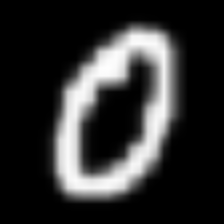

In [99]:
cv2_imshow(cv2.resize(test.astype(np.uint8).T, (224, 224)))

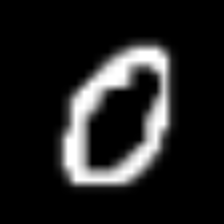

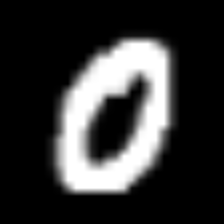

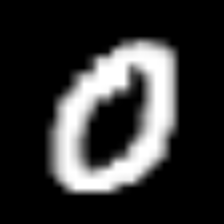

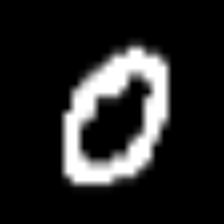

In [100]:
for i in range(4):
  Aug = data_augment(test, 0)
  dst = Aug.select_agu_strategy(i)
  cv2_imshow(cv2.resize(dst, (224, 224)).T)

In [28]:
data, label = [], []
train_data, train_label = [], []

In [29]:
new_data.shape

(553190, 28, 28)

In [30]:
ttt = new_data.copy()

In [31]:
for i, img in enumerate(ttt):
  try:
    Aug = data_augment(img, label)
    ttt[i] = Aug.select_agu_strategy(i)
  except:
    print(i)
    break

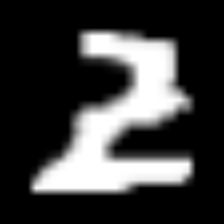

61


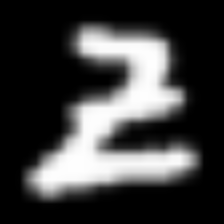

61


In [32]:
idd= -22
cv2_imshow(cv2.resize(ttt[idd].T,(224, 224)))
print(new_label[idd])
cv2_imshow(cv2.resize(new_data[idd].T,(224, 224)))
print(new_label[idd])

In [33]:
dataset = []

In [34]:
dataset = [[x, y] for x, y, in zip(ttt, new_label)]
random.shuffle(dataset)
train = np.array([n[0] for n in dataset])
label = np.array([n[1] for n in dataset])

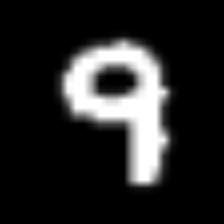

52


In [35]:
i = 54
cv2_imshow(cv2.resize(train[i].T, (224, 224)))
print(label[i])

In [36]:
print(train.shape)
print(label.shape)

(553190, 28, 28)
(553190,)


[['26', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '217.0', '255.0', '255.0', '115.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '45.0', '96.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0

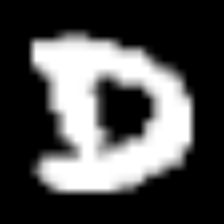

26
785


In [37]:
iddd = 534256
src = train[124232].copy()
now_content = []
dst = src.copy().reshape(-1)
now_label = label[iddd]
now_content.append(f'{now_label}')
for j in range(len(dst)):
    now_content.append(f'{dst[j]}')
final_content = [now_content]
print(final_content)
cv2_imshow(cv2.resize(dst.reshape(28, 28).T, (224, 224)))
print(label[iddd])
print(len(final_content[0]))

In [38]:
a = train.copy()

In [40]:
a = a.reshape(-1, 28*28)

In [55]:
label.reshape(-1, 1).shape

(553190, 1)

In [53]:
a.shape

(553190, 784)

In [62]:
b = np.concatenate([label.reshape(-1, 1), a], axis = 1).astype(np.uint8)

In [61]:
b[44][0]

20.0

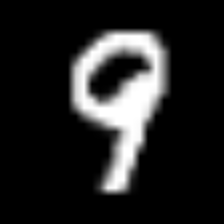

9


In [67]:
idd = 120
cv2_imshow(cv2.resize(b[idd][1:].reshape(28, 28).T, (224, 224)))
print(b[idd][0])

In [69]:
import pandas as pd

data_frame = pd.DataFrame(b)
data_frame.to_csv('augmented_emnist.csv', header = False, index = False)

In [70]:
ls

augmented_emnist.csv            Mobile_Leacky_SGD_800_100_05.h5
emnist-byclass-test.csv         Mobile_Leacky_SGD_800_100_05.h5_1/
emnist-byclass-train.csv        Mobile_ReLU_SGD_800_05.h5
images/                         my_lenet5_emnist_model_20220515.h5
mobile2                         our_handmade_dataset.csv
Mobile_ELU_SGD_1000_120_005.h5  wandb/


In [71]:
agg_csv = []
agg_csv = pd.read_csv("./augmented_emnist.csv", header=None)

In [72]:
agg_data, agg_label = convert_data_csv_to_numpy(agg_csv, sorting = False)
agg_csv = []

In [76]:
agg_data = agg_data.reshape(-1, 28, 28)
print(agg_data.shape)
print(agg_label.shape)

(553190, 28, 28)
(553190,)


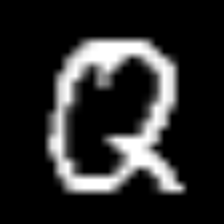

26


In [85]:
ti = 40
cv2_imshow(cv2.resize(agg_data[ti].astype(np.uint8).T, (224, 224)))
print(agg_label[ti])